Udacity Machine Learning Engineer Nanodegree Project 5 
=============

Deep Learning for Satellite Image Recognition
-------------

In [9]:
# Modules to import for project
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import numpy as np
import os
import sys
import scipy.io as sio
import random
import tensorflow as tf
import h5py
from numpy import random
from IPython.display import display, Image
from scipy import ndimage
from PIL import Image


# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

## 1. Exploring and Preparing the Data

First, we will extract and investigate the images from the SAT-6 dataset. Information about the dataset is available here: 
    
    http://csc.lsu.edu/~saikat/deepsat/ 

The dataset contains 405,000 satellite images, and is separated into 324,000 images for the training dataset and 81,000 for the testing dataset. We start by opening the mat file.

In [10]:
def open_mat(filename):
    #opens the SAT6 dataset, which is a .mat file.
    if os.path.isfile(filename): 
        print ("Current working directory contains %r" % filename)
        mat_contents = sio.loadmat(filename)
        print ("SAT6 loaded successfully.")
    else:
        print ("Download %r to current working directory" % filename)
    return mat_contents

mat_sat_6 = 'sat-6-full.mat'

sat_6 = open_mat(mat_sat_6)

Current working directory contains 'sat-6-full.mat'
SAT6 loaded successfully.


Next, we will explore the dataset.

In [11]:
def investigate_dict(a, b):
    keys_list = a.keys()
    keys_str = ', '.join(keys_list)
    lst = []
    print("File is a %r, with keys %r." % (type(a), keys_str))
    for k in b:
        array = a.get(k)
        print('%r has dimensions %r' % (k, array.shape))
        lst.append(array)
    return lst

sets = ['train_x', 'train_y', 'test_x', 'test_y']

raw_x_train, raw_y_train, raw_x_test, raw_y_test = investigate_dict(sat_6, sets)
print(sat_6['annotations'])

File is a <type 'dict'>, with keys 'train_x, train_y, __header__, __globals__, __version__, annotations, test_y, test_x'.
'train_x' has dimensions (28, 28, 4, 324000)
'train_y' has dimensions (6, 324000)
'test_x' has dimensions (28, 28, 4, 81000)
'test_y' has dimensions (6, 81000)
[[array([u'100000'], 
      dtype='<U6')
  array([u'building'], 
      dtype='<U8')]
 [array([u'010000'], 
      dtype='<U6')
  array([u'barren land'], 
      dtype='<U11')]
 [array([u'001000'], 
      dtype='<U6')
  array([u'trees'], 
      dtype='<U5')]
 [array([u'000100'], 
      dtype='<U6')
  array([u'grassland'], 
      dtype='<U9')]
 [array([u'000010'], 
      dtype='<U6')
  array([u'road'], 
      dtype='<U4')]
 [array([u'000001'], 
      dtype='<U6')
  array([u'water'], 
      dtype='<U5')]]


There are 324,000 training images and 81,000 testing images. Each image is 28x28, meaning each picture has 784 pixels. Each image also has 4 layers (Red, Green, Blue and Near-Infared), and is labeled with a binary vector. The vector has 6 elements and each element corresponds with the six classes the image could belong to (buildings, barren land, trees, roads, buildings and water bodies). 

Let's change the dimensions of the array so that the image index is the first dimension, the type of layer is the second, and the pixels are the third. This will make it simpler to use.

In [12]:
def change_dim(a):
    lst = []
    
    for i in a:
        
        if len(i.shape) == 4:
            i_2 = np.rollaxis(i, 3)
            i_3 = np.rollaxis(i_2, 3, start = 1)
            lst.append(i_3)
        
        elif len(i.shape) == 2:
            i_4 = np.rollaxis(i, 1)
            lst.append(i_4)
        
        else:
            print('Dimensions of arrays do not work')
    
    return lst


raw = [raw_x_train, raw_y_train, raw_x_test, raw_y_test]

switch_x_train, switch_y_train, switch_x_test, switch_y_test = change_dim(raw)

print(switch_x_train.shape)
print(switch_y_train.shape)
print(switch_x_test.shape)
print(switch_y_test.shape)

(324000, 4, 28, 28)
(324000, 6)
(81000, 4, 28, 28)
(81000, 6)


Let's view a sample of the images and their corresponding labels.

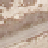

barren_land


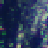

water_bodies


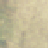

barren_land


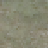

grassland


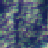

water_bodies


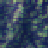

water_bodies


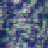

water_bodies


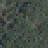

trees


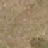

barren_land


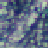

water_bodies


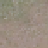

grassland


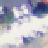

buildings


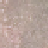

barren_land


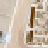

barren_land


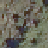

trees


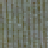

grassland


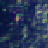

water_bodies


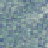

water_bodies


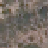

grassland


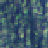

water_bodies


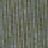

grassland


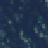

water_bodies


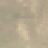

barren_land


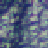

water_bodies


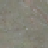

grassland


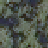

trees


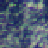

water_bodies


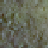

grassland


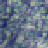

water_bodies


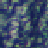

water_bodies


In [13]:
def sample_images(labels, x_data, y_data, n):
    
    
    for i in range(n):
        r = np.random.choice(len(x_data))
        #Create an rgb array
        rgbArray = np.zeros((28,28,3), 'uint8')
        rgbArray[..., 0] = x_data[r,0,...]
        rgbArray[..., 1] = x_data[r,1,...]
        rgbArray[..., 2] = x_data[r,2,...]
        img = Image.fromarray(rgbArray)
        out = img.resize((48, 48))
        display(out)

        #returns the index of 1 from the label array
        label_index = y_data[r].tolist().index(1)
        print(labels[label_index])

land_cover = ['buildings', 'barren_land', 'trees', 'grassland', 'roads', 'water_bodies']

sample_images(land_cover, switch_x_train, switch_y_train, 30)

Let's check to see that the data is balanced across sets.

'y_train' has [14923, 73397, 56809, 50347, 8192, 120332] for land_cover classes
'y_test' has [3714, 18367, 14185, 12596, 2070, 30068] for land_cover classes


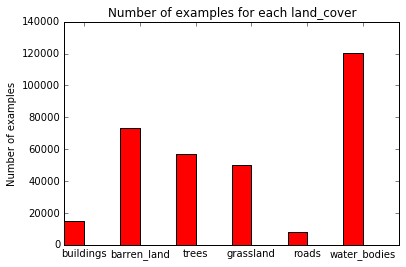

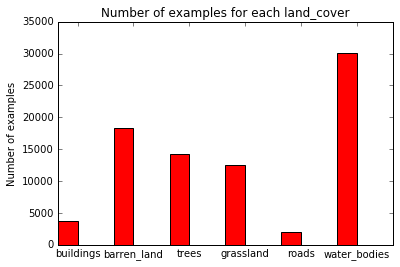

In [14]:
labels = [switch_y_train, switch_y_test]
str_labels = ['y_train', 'y_test']

for i in range(len(labels)):
    total = []
    count = [0]*len(land_cover)
    for j in range(len(labels[i])):
        count = [x + y for x, y in zip(count, labels[i][j])]
    
    print('%r has %r for land_cover classes' % (str_labels[i], count))
    
    ind = np.arange(6)
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, count, width, color='r')
    ax.set_ylabel('Number of examples')
    ax.set_title('Number of examples for each land_cover')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(land_cover)

By visual inspection, the data looks balanced across sets. While the data is balanced across sets (training, validation, and testing) the data is not balanced across classes within each set. This is not necessarily bad, since the distribution of the classes reflects the distribution of land cover types that a classifier trained on this data will see.

Using all 405,000 images to train and test our CNN is beyond the scope of this project. Instead, we will cut our dataset to 20,000 training images, 5,000 cross-validation images, and 5,000 test images. Let's start by shuffling the data.

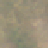

barren_land


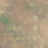

barren_land


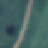

grassland


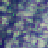

water_bodies


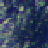

water_bodies


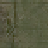

grassland


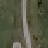

grassland


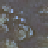

trees


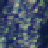

water_bodies


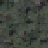

trees


In [15]:
#Shuffle the data
perm_train = random.permutation(len(switch_x_train))
shuffled_x_train = switch_x_train[perm_train]
shuffled_y_train = switch_y_train[perm_train]

perm_test = random.permutation(len(switch_x_test))
shuffled_x_test = switch_x_train[perm_test]
shuffled_y_test = switch_y_train[perm_test]

#Verify that the labels and images are still correct
sample_images(land_cover, shuffled_x_train, shuffled_y_train, 5)
sample_images(land_cover, shuffled_x_test, shuffled_y_test, 5)

In [16]:


X_train = shuffled_x_train[0:20000]
y_train = shuffled_y_train[0:20000]
X_valid = shuffled_x_train[20001:25001]
y_valid = shuffled_y_train[20001:25001]
X_test = shuffled_x_test[0:5000]
y_test = shuffled_y_test[0:5000]

Next, we will convert each example into a flat matrix, which will make it more adaptive to our models.

In [17]:
image_size = 28
color_layers = 4

def reformat(dataset):
  dataset = dataset.reshape((len(dataset), image_size * image_size * color_layers)).astype(np.float32)
  return dataset

X_train = reformat(X_train)
X_valid = reformat(X_valid)
X_test = reformat(X_test)
print ('Training set', X_train.shape)
print ('Valid set', X_valid.shape)
print ('Test set', X_test.shape)

Training set (20000, 3136)
Valid set (5000, 3136)
Test set (5000, 3136)


When executing numerical computations, we have to be concerned about calculating values that are too large or too small, which can introduce error into our calculations. In order to avoid error, we want our mean to be equal to zero and our variances to be equal across variables. Our dataset includes the pixel values of four layers (Red, Green, Blue, and Near-Infared) with values between 0 and 255. We can normalize the values, which will convert each pixel value to a value between -1 and 1.

In [18]:
mean = 128

def normalize(dataset):
    z = np.ones(dataset.shape)*128
    a = (dataset-z)/z
    return np.float32(a)
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)
print ('Training set', X_train.shape)
print ('Valid set', X_valid.shape)
print ('Test set', X_test.shape)

Training set (20000, 3136)
Valid set (5000, 3136)
Test set (5000, 3136)


Let's take a random example from each set and verify that the pixel values are normalized.

In [19]:
print(X_train[0])
print(X_valid[0])
print(X_test[0])

[ 0.578125   0.6015625  0.609375  ...,  0.5859375  0.5859375  0.5703125]
[ 0.25       0.2734375  0.296875  ...,  0.3046875  0.2890625  0.2890625]
[ 0.015625   0.140625  -0.015625  ...,  0.1171875  0.1484375  0.1328125]


Now that our data is preprocessed, let's download them as h5f files for later use.

In [20]:
Xy_set = ['X_train', 'y-train', 'X_valid', 'y_valid', 'X_test', 'y_test']
Xy_norm_set = [X_train, y_train, X_valid, y_valid, X_test, y_test]


h5f = h5py.File('sat-6.h5', 'w')
for i in range(len(Xy_set)):
    h5f.create_dataset(Xy_set[i], data=Xy_norm_set[i])
    print(Xy_set[i] + ' successfully written to sat-6.h5')

h5f.close()

X_train successfully written to sat-6.h5
y-train successfully written to sat-6.h5
X_valid successfully written to sat-6.h5
y_valid successfully written to sat-6.h5
X_test successfully written to sat-6.h5
y_test successfully written to sat-6.h5
